In [61]:
modelIn = "ClickbaitTest"
modelOut = "ClickbaitTest2"

                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
                                              # "bert-base-cased" <---
problem_type =  "regression"                  # Possible values: "regression", "single_label_classification", "multi_label_classification"
num_labels = 1                                # 5
dataCuratedPath = "Data/Curated"              # Columns separated by ";" to avoid numeric formats nightmare:
                                              #    'postText', 'targetTitle', 'targetDescription', 'id', 'truthMean
actualOutput = 'truthMean'
computedOutput = "labelC"
inputColumn = 'postText'
removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.2                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(modelIn)
model = AutoModelForSequenceClassification.from_pretrained(
   modelIn,
   problem_type=problem_type,
   num_labels = num_labels)

In [4]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [6]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Hello, how are you?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Bonjour, comment ça va ?")))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour, comment ça va ?")))
print(tokenizer.decode(tokenizer.encode("Bonjour, comment ça va ?")))

{'input_ids': [101, 171, 1320, 25028, 1197, 117, 7368, 11019, 191, 1161, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['hello', ',', 'how', 'are', 'you', '?']
[101, 171, 1320, 25028, 1197, 117, 7368, 11019, 191, 1161, 136, 102]
[171, 1320, 25028, 1197, 117, 7368, 11019, 191, 1161, 136]
['[CLS]', 'b', '##on', '##jou', '##r', ',', 'comment', 'ca', 'v', '##a', '?', '[SEP]']
[CLS] bonjour, comment ca va? [SEP]


In [7]:
import datasets as ds

In [8]:
curated = ds.load_from_disk(dataCuratedPath)

In [9]:
curated.to_pandas()

,postText,targetTitle,targetDescription,truthMean,id
0,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",Law enforcement agency analysis uncovers proba...,0.066667,804113781580328960
1,The key to truly great chicken soup,A Superior Chicken Soup,For the best rendition of this American classi...,0.733333,804119512010424320
2,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,The Afghan women risking all to join the police.,0.333333,804121272967983104
3,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,"Many factors are dragging down NFL ratings, in...",0.066667,804123103995580416
4,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,"Seattle Seahawks news, rumors, scores, schedul...",0.133333,804126501117435904
...,...,...,...,...,...
21907,Man who received world's first penis transplan...,World's first penis transplant patient is set ...,"Surgeons at Stellenbosch University, who carri...",0.600000,609056814819323905
21908,"RT @NYTSports: Abby didn't start, team couldn'...","At Women’s World Cup, Tie Leaves U.S. on Solid...",With Abby Wambach not starting for the first t...,0.266667,610125815116865536
21909,Obama defends Affordable Care Act ahead of Sup...,Obama Defends Health Law Ahead of Supreme Cour...,President Obama talks at the G7 summit in Germ...,0.400000,608338587495628801
21910,New study of the Deflategate report concludes ...,Deflating ‘Deflategate’,A new study weakens the case against the Patri...,0.400000,609684420082180096


In [10]:
longueur= len(curated)
longueur

21912

In [11]:
trie=sorted(curated[actualOutput])

In [12]:
import matplotlib.pyplot as plt

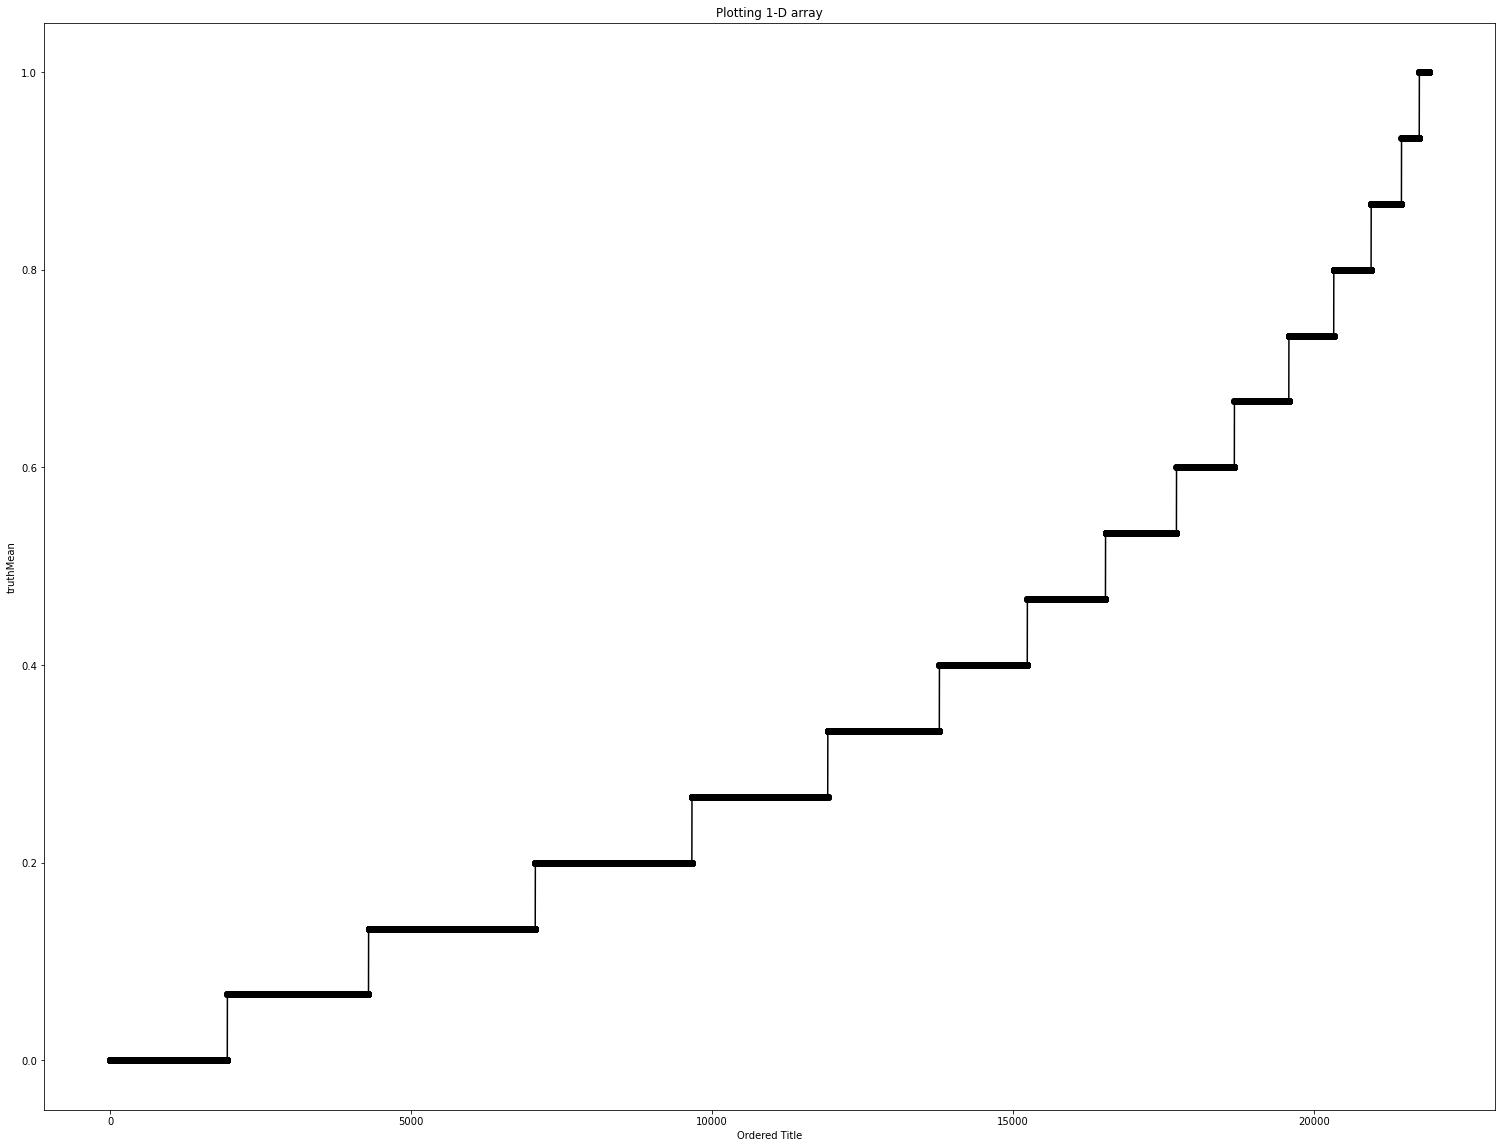

In [13]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(actualOutput)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [14]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[]

In [15]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            # str(int(sample[LCfraction]*100)), # on donne direct le résultat pour voir si accuracy == 1
            #padding=True,
            #truncation=True,
            #max_length=30
            )

    fraction = sample[actualOutput]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    
    # print( fraction, tokenized_sample["input_ids"], tokenized_sample["labels"], sample[inputColumn])
    
    return tokenized_sample

In [16]:
tokenized_curated = curated.map(tokenize) #, batched=True)

  0%|          | 0/21912 [00:00<?, ?ex/s]

In [17]:
tokenized_curated

Dataset({
    features: ['postText', 'targetTitle', 'targetDescription', 'truthMean', 'id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 21912
})

In [18]:
tokenized_curated.to_pandas().describe()

,truthMean,labels
count,21912.000000,21912.000000
mean,0.327942,0.327942
std,0.250260,0.250260
min,0.000000,0.000000
25%,0.133333,0.133333
50%,0.266667,0.266667
75%,0.466667,0.466667
max,1.000000,1.000000


In [19]:
print(tokenized_curated[0:3])

{'postText': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'The key to truly great chicken soup', 'Afghan policewomen face down their fears to serve'], 'targetTitle': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'A Superior Chicken Soup ', '100 Women 2016: On the frontline with the women policing the peace in Afghanistan'], 'targetDescription': ['Law enforcement agency analysis uncovers probable matches connected to terrorism, money laundering and organised crime', 'For the best rendition of this American classic, start with a whole bird.', 'The Afghan women risking all to join the police.'], 'truthMean': [0.06666666666, 0.73333333332, 0.33333333330000003], 'id': ['804113781580328960', '804119512010424320', '804121272967983104'], 'input_ids': [[101, 13316, 7363, 4580, 131, 27772, 23043, 6743, 124, 117, 2260, 2666, 1106, 6321, 13037, 102], [101, 1103, 2501, 1106, 5098, 1632, 9323, 13128, 102], [101, 170, 2087, 23136, 2021, 12821, 2354, 1339, 

In [20]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [21]:
tokenized_curated2['train'].to_pandas()

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels
0,Eight feared dead as avalanche hits Japanese h...,Eight Feared Dead as Avalanche Hits Japan Ski ...,"Hours before the incident, officials warned th...",0.066667,846280649770225665,"[101, 2022, 8253, 2044, 1112, 170, 7501, 23742...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.066667
1,Donald Trump defends his recent phone call wit...,Trump Suggests Using Bedrock China Policy as B...,Defending his recent phone call with Taiwan’s ...,0.133333,808072671774855168,"[101, 1274, 18728, 189, 27321, 6472, 1116, 111...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
2,"Strangers living ""literally around the corner""...","Strangers living ""around the corner"" from each...","After decades go by, the two women finally con...",0.533333,837803530614362112,"[101, 15712, 1690, 107, 6290, 1213, 1103, 2655...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333
3,These are the victims of the Berlin truck attack,These Are The Victims Of The Berlin Truck Atta...,,0.133333,811972338266861568,"[101, 1292, 1132, 1103, 5256, 1104, 1103, 1129...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.133333
4,A weather geek's guide to why it's so freaking...,"The polar vortex is here, but it's competing w...",The polar vortex ain't what it used to be.,0.666667,809457756256223237,"[101, 170, 4250, 176, 20059, 112, 188, 6388, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.666667
...,...,...,...,...,...,...,...,...,...
17524,Tinder reveals the most right-swiped names of ...,Are YOU popular on Tinder? Dating app reveals ...,The top ranking name in the UK for a boy is Ha...,0.800000,809495084332937216,"[101, 14086, 2692, 7189, 1103, 1211, 1268, 118...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.800000
17525,NYSE Arca platform for trading ETFs suffers te...,NYSE Exchange-Traded Fund Platform Hit by Tech...,NYSE Arca suffered a technical glitch Monday m...,0.000000,810889790140846080,"[101, 183, 6834, 1162, 10591, 1161, 3482, 1111...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000
17526,The people stuck in the crossfire in Iraq,The people stuck in the crossfire in Iraq,Iraqi forces are engaged in a fierce battle to...,0.400000,850680969623482368,"[101, 1103, 1234, 5342, 1107, 1103, 2771, 7117...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.400000
17527,Afghan family of 5 with visas being held in tw...,Afghan family with visas held in California an...,Afghan family with visas held in Calif. and at...,0.333333,838756541192945665,"[101, 170, 2087, 23136, 1266, 1104, 126, 1114,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.333333


In [22]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [23]:
tokenized_curated4 = tokenized_curated3

In [24]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17529
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4383
    })
})

In [25]:
print(tokenized_curated4["train"][0:20])

{'input_ids': [[101, 2022, 8253, 2044, 1112, 170, 7501, 23742, 4919, 179, 26519, 13309, 1344, 1278, 1651, 102], [101, 1274, 18728, 189, 27321, 6472, 1116, 1117, 2793, 2179, 1840, 1114, 27629, 1182, 5491, 112, 188, 2084, 102], [101, 15712, 1690, 107, 6290, 1213, 1103, 2655, 107, 1121, 1296, 1168, 7290, 1152, 112, 1231, 5919, 102], [101, 1292, 1132, 1103, 5256, 1104, 1103, 1129, 20754, 4202, 2035, 102], [101, 170, 4250, 176, 20059, 112, 188, 6388, 1106, 1725, 1122, 112, 188, 1177, 14599, 2504, 1796, 102], [101, 5250, 3309, 4873, 112, 188, 3315, 9834, 6470, 1144, 1151, 7548, 1121, 11019, 2646, 14467, 4558, 1465, 7237, 1116, 119, 102], [101, 10552, 7221, 1144, 2083, 1204, 16150, 3680, 1136, 5425, 1106, 4917, 1119, 10118, 1106, 175, 5567, 111, 1821, 1643, 132, 1793, 1106, 4750, 3085, 14409, 131, 102], [101, 1103, 189, 27321, 4077, 1616, 1107, 16946, 1465, 1110, 1684, 1106, 5194, 1167, 2880, 3239, 1106, 1157, 2546, 119, 102], [101, 1107, 7854, 112, 188, 26232, 131, 1103, 125, 3243, 2490, 111

In [26]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  # eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  # save_steps = 50,
                                  # save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  optim= 'adamw_torch',
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  learning_rate=learning_rate,
                                  weight_decay=weight_decay,
                                  #push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

In [28]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [29]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  # callbacks = [EarlyStoppingCallback(early_stopping_patience=5)], #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [32]:
# faire la boucle avec le trainer pytorch
# %pdb
if (modelIn != modelOut):
    trainer.train()

***** Running training *****
  Num examples = 17529
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4384


Step,Training Loss,Validation Loss,Mse
500,0.025300,0.021854,0.021854
1000,0.024300,0.022229,0.022229
1500,0.024300,0.021690,0.021690
2000,0.024400,0.021657,0.021657
2500,0.023400,0.021722,0.021722
3000,0.023500,0.021631,0.021631
3500,0.023700,0.021527,0.021527
4000,0.023100,0.021549,0.021549


***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
Saving model checkpoint to ClickbaitTest\checkpoint-500
Configuration saved in ClickbaitTest\checkpoint-500\config.json
Model weights saved in ClickbaitTest\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ClickbaitTest\checkpoint-500\tokenizer_config.json
Special tokens file saved in ClickbaitTest\checkpoint-500\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
Saving model checkpoint to ClickbaitTest\checkpoint-1000
Configuration saved in ClickbaitTest\checkpoint-1000\config.json
Model weights saved in ClickbaitTest\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ClickbaitTest\checkpoint-1000\tokenizer_config.json
Special tokens file saved in ClickbaitTest\checkpoint-1000\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
Saving model checkpoint to ClickbaitTest\checkpoint-1500
Configuration sav

In [33]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16


{'eval_loss': 0.022229202091693878,
 'eval_mse': 0.022229202817381284,
 'eval_runtime': 6.7916,
 'eval_samples_per_second': 645.361,
 'eval_steps_per_second': 40.344,
 'epoch': 4.0}

In [60]:
modelPath, checkpoint

('ClickbaitTest', 'ClickbaitTest2')

In [34]:
# Sauver le modèle sur le disque
if (modelIn != modelOut):
    model.save_pretrained(modelPath)

Configuration saved in ClickbaitTest\config.json
Model weights saved in ClickbaitTest\pytorch_model.bin


In [35]:
if (modelIn != modelOut):
    tokenizer.save_vocabulary(modelPath)

In [36]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "test" #  "train" # "test"

In [37]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated2[overfitting])

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: postText, targetTitle, targetDescription, truthMean, id. If postText, targetTitle, targetDescription, truthMean, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4383
  Batch size = 16


In [38]:
predictions.predictions

array([[0.14846474],
       [0.13847741],
       [0.26514578],
       ...,
       [0.5361224 ],
       [0.5729617 ],
       [0.41403303]], dtype=float32)

In [39]:
predictions.metrics

{'test_loss': 0.022229202091693878,
 'test_mse': 0.022229202817381284,
 'test_runtime': 9.0949,
 'test_samples_per_second': 481.918,
 'test_steps_per_second': 30.127}

In [40]:
tct = tokenized_curated2[overfitting].to_pandas()

In [41]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels
0,Hospitals overcharging for #stents will be pen...,Govt Begins Crackdown On Hospital Overcharging...,"Govt Cracks Whip, Asks Hospitals To Stock Sten...",0.000000,832854687141490689,"[101, 8894, 1166, 7147, 10805, 1158, 1111, 108...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000
1,"Kiesza discusses ""immense tragedy"" preceding s...",Kiesza Discusses 'Immense Tragedy' Preceding S...,âHideawayâ star Kiesza discusses âDearly...,0.200000,824346385575268368,"[101, 180, 1905, 3293, 16900, 107, 14934, 1234...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000
2,"Inside Lapland's palatial Icehotel, with its -...",What it's like to sleep in a (luxury) freezer:...,MailOnline's Annabel Fenwick Elliott spent a n...,0.133333,835902333334732800,"[101, 1656, 4443, 1931, 112, 188, 185, 5971, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
3,Van crashes into plane at Dallas airport via @...,Van Crashes Into Plane at Dallas Airport,A catering van crashed into the rear of a jetl...,0.000000,609601544137375744,"[101, 3498, 21110, 1154, 4261, 1120, 5358, 239...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000
4,Why sex harassment scandals like Uber's are bo...,Why sexual harassment scandals like Uber's are...,Letting other big-name companies shoulder the ...,0.466667,834211808743419904,"[101, 1725, 2673, 17514, 10083, 1116, 1176, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.466667
...,...,...,...,...,...,...,...,...,...
4378,Soulja Boy calls out Kanye West's fashion infl...,Soulja Boy Calls Out Kanye West's Fashion Infl...,"Soulja Boy keeps on talking, this time calling...",0.133333,821820709567680513,"[101, 3960, 3174, 2298, 3675, 1149, 24181, 338...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
4379,Elon Musk reveals his plans for ending traffic...,Land And Air Travel Aren't Enough For Elon Mus...,The restless Tesla/SpaceX CEO is bringing his ...,0.133333,858123680454512640,"[101, 8468, 1320, 182, 24493, 7189, 1117, 2714...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
4380,Britain's eccentric lay-by businesses,On the roads discovering Britain's eccentric l...,"Lay-by businesses, selling everything from bur...",0.733333,609535452782198785,"[101, 9304, 5168, 1394, 112, 188, 20276, 3191,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.733333
4381,This man wore a suit to meet his new nephew be...,This man wore a suit to meet his new nephew be...,Iris Kessler tweeted this (amazing) picture of...,0.600000,816983857350275072,"[101, 1142, 1299, 4307, 170, 4228, 1106, 2283,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000


In [42]:
if num_labels == 1:
    tct[computedOutput] = predictions.predictions
else:
    tct[computedOutput] = np.argmax(predictions.predictions, axis=1)   

In [43]:
tct1 = tct.sort_values(actualOutput)
tct2 = tct.sort_values(computedOutput)

In [44]:
palette = ["r", "g", "b", "c", "m"]

In [45]:
if num_labels == 1:
    color1 = [val for val in tct1[computedOutput]]
    color2 = [val for val in tct1[actualOutput]]
else:
    color1 = [palette[val] for val in tct1[computedOutput]]
    color2 = [palette[val] for val in tct1[actualOutput]]

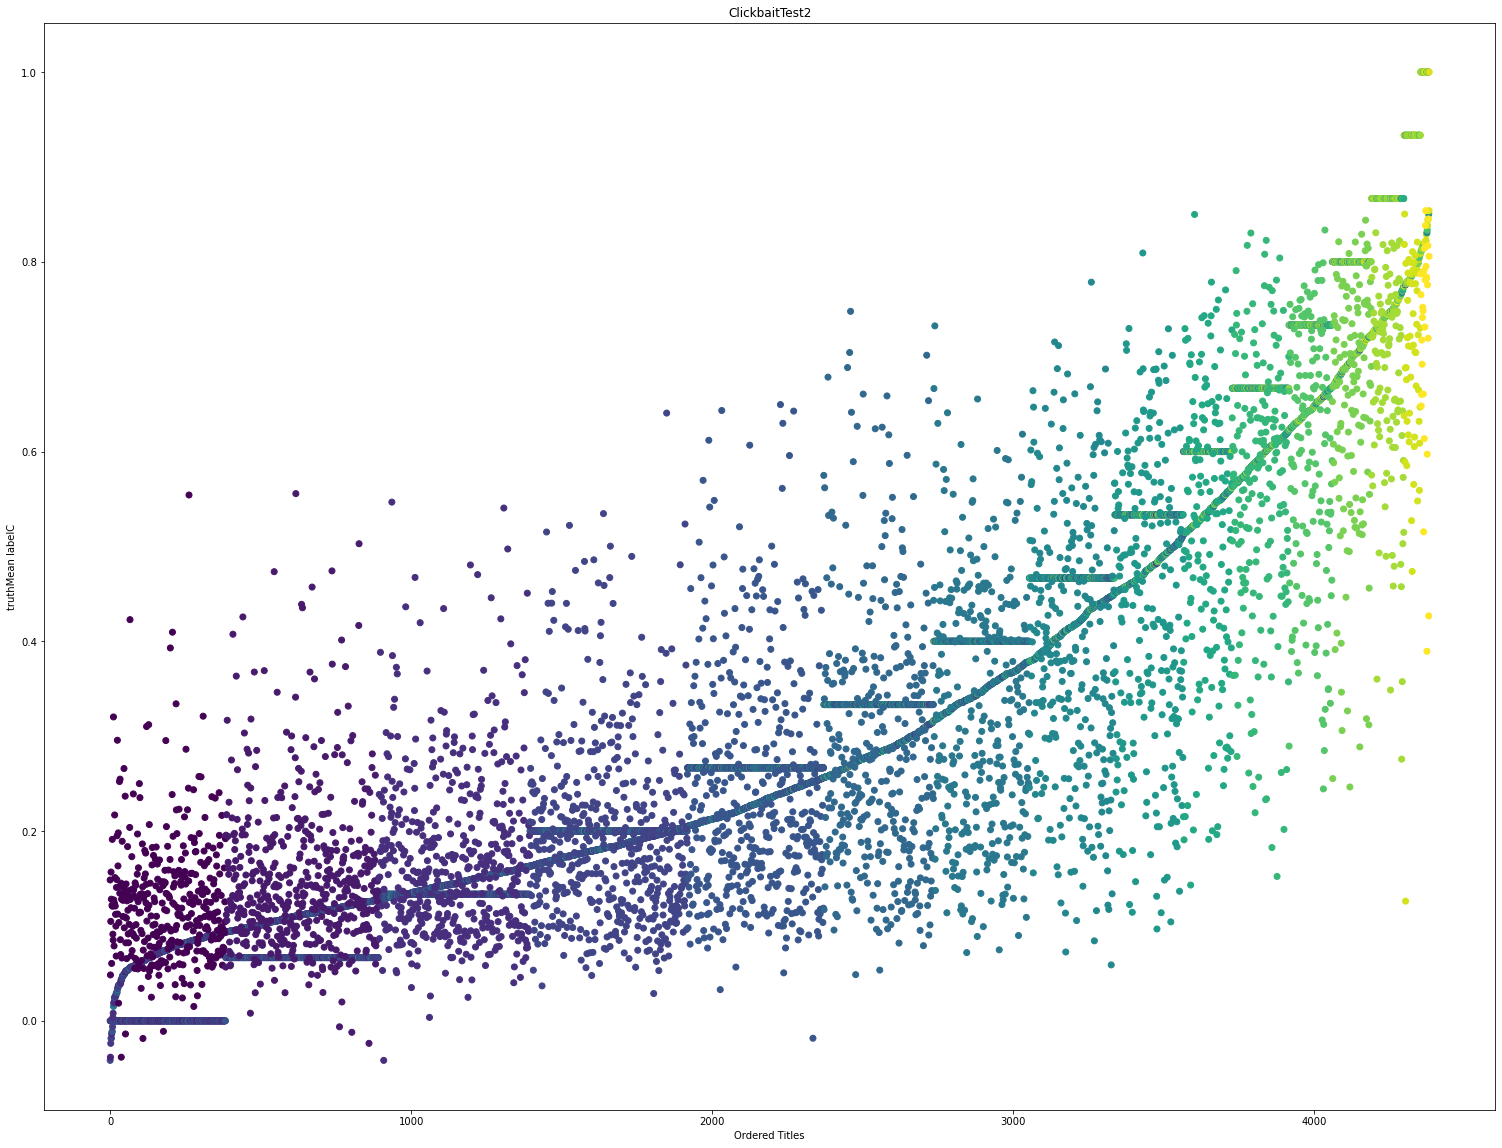

In [46]:
plt.figure(figsize=(26, 20))
plt.title(checkpoint)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = np.array(range(0, tct1.shape[0]))
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = "o", label = "Array elements")

In [47]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels,labelC
0,Hospitals overcharging for #stents will be pen...,Govt Begins Crackdown On Hospital Overcharging...,"Govt Cracks Whip, Asks Hospitals To Stock Sten...",0.000000,832854687141490689,"[101, 8894, 1166, 7147, 10805, 1158, 1111, 108...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000,0.148465
1,"Kiesza discusses ""immense tragedy"" preceding s...",Kiesza Discusses 'Immense Tragedy' Preceding S...,âHideawayâ star Kiesza discusses âDearly...,0.200000,824346385575268368,"[101, 180, 1905, 3293, 16900, 107, 14934, 1234...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.138477
2,"Inside Lapland's palatial Icehotel, with its -...",What it's like to sleep in a (luxury) freezer:...,MailOnline's Annabel Fenwick Elliott spent a n...,0.133333,835902333334732800,"[101, 1656, 4443, 1931, 112, 188, 185, 5971, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.265146
3,Van crashes into plane at Dallas airport via @...,Van Crashes Into Plane at Dallas Airport,A catering van crashed into the rear of a jetl...,0.000000,609601544137375744,"[101, 3498, 21110, 1154, 4261, 1120, 5358, 239...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000,0.185028
4,Why sex harassment scandals like Uber's are bo...,Why sexual harassment scandals like Uber's are...,Letting other big-name companies shoulder the ...,0.466667,834211808743419904,"[101, 1725, 2673, 17514, 10083, 1116, 1176, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.466667,0.574904
...,...,...,...,...,...,...,...,...,...,...
4378,Soulja Boy calls out Kanye West's fashion infl...,Soulja Boy Calls Out Kanye West's Fashion Infl...,"Soulja Boy keeps on talking, this time calling...",0.133333,821820709567680513,"[101, 3960, 3174, 2298, 3675, 1149, 24181, 338...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.186222
4379,Elon Musk reveals his plans for ending traffic...,Land And Air Travel Aren't Enough For Elon Mus...,The restless Tesla/SpaceX CEO is bringing his ...,0.133333,858123680454512640,"[101, 8468, 1320, 182, 24493, 7189, 1117, 2714...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.205253
4380,Britain's eccentric lay-by businesses,On the roads discovering Britain's eccentric l...,"Lay-by businesses, selling everything from bur...",0.733333,609535452782198785,"[101, 9304, 5168, 1394, 112, 188, 20276, 3191,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.733333,0.536122
4381,This man wore a suit to meet his new nephew be...,This man wore a suit to meet his new nephew be...,Iris Kessler tweeted this (amazing) picture of...,0.600000,816983857350275072,"[101, 1142, 1299, 4307, 170, 4228, 1106, 2283,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.572962


In [48]:
tct[[computedOutput, actualOutput]].describe()

,labelC,truthMean
count,4383.000000,4383.000000
mean,0.302727,0.327645
std,0.201650,0.249574
min,-0.041694,0.000000
25%,0.141782,0.133333
50%,0.235256,0.266667
75%,0.439643,0.466667
max,0.853837,1.000000


In [49]:
tct.corr()

,truthMean,labels,labelC
truthMean,1.000000,1.000000,0.808089
labels,1.000000,1.000000,0.808089
labelC,0.808089,0.808089,1.000000


In [50]:
from transformers import pipeline

In [51]:
model.to(torch.device("cpu"))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [52]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [53]:
classifier

In [54]:
classifier("Nous sommes très heureux de vous présenter la bibliothèque 🤗 Transformers.")

[{'label': 'LABEL_0', 'score': 0.5740309953689575}]

In [55]:
classifier(["The key to truly great chicken soup", "La clef d'une bonne soupe au poulet"])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'LABEL_0', 'score': 0.6501203179359436},
 {'label': 'LABEL_0', 'score': 0.6026092171669006}]

In [56]:
classifier("Traité de mathématiques amusantes.")

[{'label': 'LABEL_0', 'score': 0.63006192445755}]

In [57]:
tct.loc[tct.labelC != tct.labels]

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels,labelC
0,Hospitals overcharging for #stents will be pen...,Govt Begins Crackdown On Hospital Overcharging...,"Govt Cracks Whip, Asks Hospitals To Stock Sten...",0.000000,832854687141490689,"[101, 8894, 1166, 7147, 10805, 1158, 1111, 108...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000,0.148465
1,"Kiesza discusses ""immense tragedy"" preceding s...",Kiesza Discusses 'Immense Tragedy' Preceding S...,âHideawayâ star Kiesza discusses âDearly...,0.200000,824346385575268368,"[101, 180, 1905, 3293, 16900, 107, 14934, 1234...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.138477
2,"Inside Lapland's palatial Icehotel, with its -...",What it's like to sleep in a (luxury) freezer:...,MailOnline's Annabel Fenwick Elliott spent a n...,0.133333,835902333334732800,"[101, 1656, 4443, 1931, 112, 188, 185, 5971, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.265146
3,Van crashes into plane at Dallas airport via @...,Van Crashes Into Plane at Dallas Airport,A catering van crashed into the rear of a jetl...,0.000000,609601544137375744,"[101, 3498, 21110, 1154, 4261, 1120, 5358, 239...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000,0.185028
4,Why sex harassment scandals like Uber's are bo...,Why sexual harassment scandals like Uber's are...,Letting other big-name companies shoulder the ...,0.466667,834211808743419904,"[101, 1725, 2673, 17514, 10083, 1116, 1176, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.466667,0.574904
...,...,...,...,...,...,...,...,...,...,...
4378,Soulja Boy calls out Kanye West's fashion infl...,Soulja Boy Calls Out Kanye West's Fashion Infl...,"Soulja Boy keeps on talking, this time calling...",0.133333,821820709567680513,"[101, 3960, 3174, 2298, 3675, 1149, 24181, 338...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.186222
4379,Elon Musk reveals his plans for ending traffic...,Land And Air Travel Aren't Enough For Elon Mus...,The restless Tesla/SpaceX CEO is bringing his ...,0.133333,858123680454512640,"[101, 8468, 1320, 182, 24493, 7189, 1117, 2714...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333,0.205253
4380,Britain's eccentric lay-by businesses,On the roads discovering Britain's eccentric l...,"Lay-by businesses, selling everything from bur...",0.733333,609535452782198785,"[101, 9304, 5168, 1394, 112, 188, 20276, 3191,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.733333,0.536122
4381,This man wore a suit to meet his new nephew be...,This man wore a suit to meet his new nephew be...,Iris Kessler tweeted this (amazing) picture of...,0.600000,816983857350275072,"[101, 1142, 1299, 4307, 170, 4228, 1106, 2283,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.572962


In [58]:
classifier("99% des gens n'arrivent pas à voir le chien sur cette image", return_all_scores=True)

[[{'label': 'LABEL_0', 'score': 0.5732000470161438}]]